In [1]:
# ========== 1. 挂载 Google Drive ==========
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# ========== 2. 解压项目 ==========
# 假设你把 plantdoc.zip 放在 Drive 的 MyDrive 根目录

%%bash
unzip -q plantdoc.zip

In [7]:
%%bash
# 单元 3：安装依赖
cd /content/plantdoc

pip install -q numpy pandas matplotlib seaborn scikit-image opencv-python-headless scikit-learn tqdm pillow

✓ 路径与依赖就绪

--- 加载数据 ---


Loading test: 100%|██████████| 398/398 [00:01<00:00, 315.36it/s]


训练 (1730, 256, 256, 3) | 验证 (360, 256, 256, 3) | 测试 (398, 256, 256, 3)

--- 特征提取 ---
HOG -> StandardScaler + PCA(256)
Color+LBP -> StandardScaler
最终特征维度: 378

--- GridSearchCV ---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
✓ 最优参数: {'C': 100, 'gamma': 'scale'}

--- 测试集评估 ---

Accuracy: 0.2412
Macro F1: 0.1933
Weighted F1: 0.2250

Classification Report:
                            precision    recall  f1-score   support

           Apple Scab Leaf       0.00      0.00      0.00        14
       Corn Gray leaf spot       0.43      0.27      0.33        11
  Potato leaf early blight       0.05      0.06      0.05        18
   Potato leaf late blight       0.24      0.29      0.26        17
Squash Powdery mildew leaf       0.36      0.76      0.49        21
  Tomato Early blight leaf       0.09      0.13      0.11        15
 Tomato Septoria leaf spot       0.15      0.27      0.20        22
                apple leaf       0.36      0.29      0.32        14
           appl

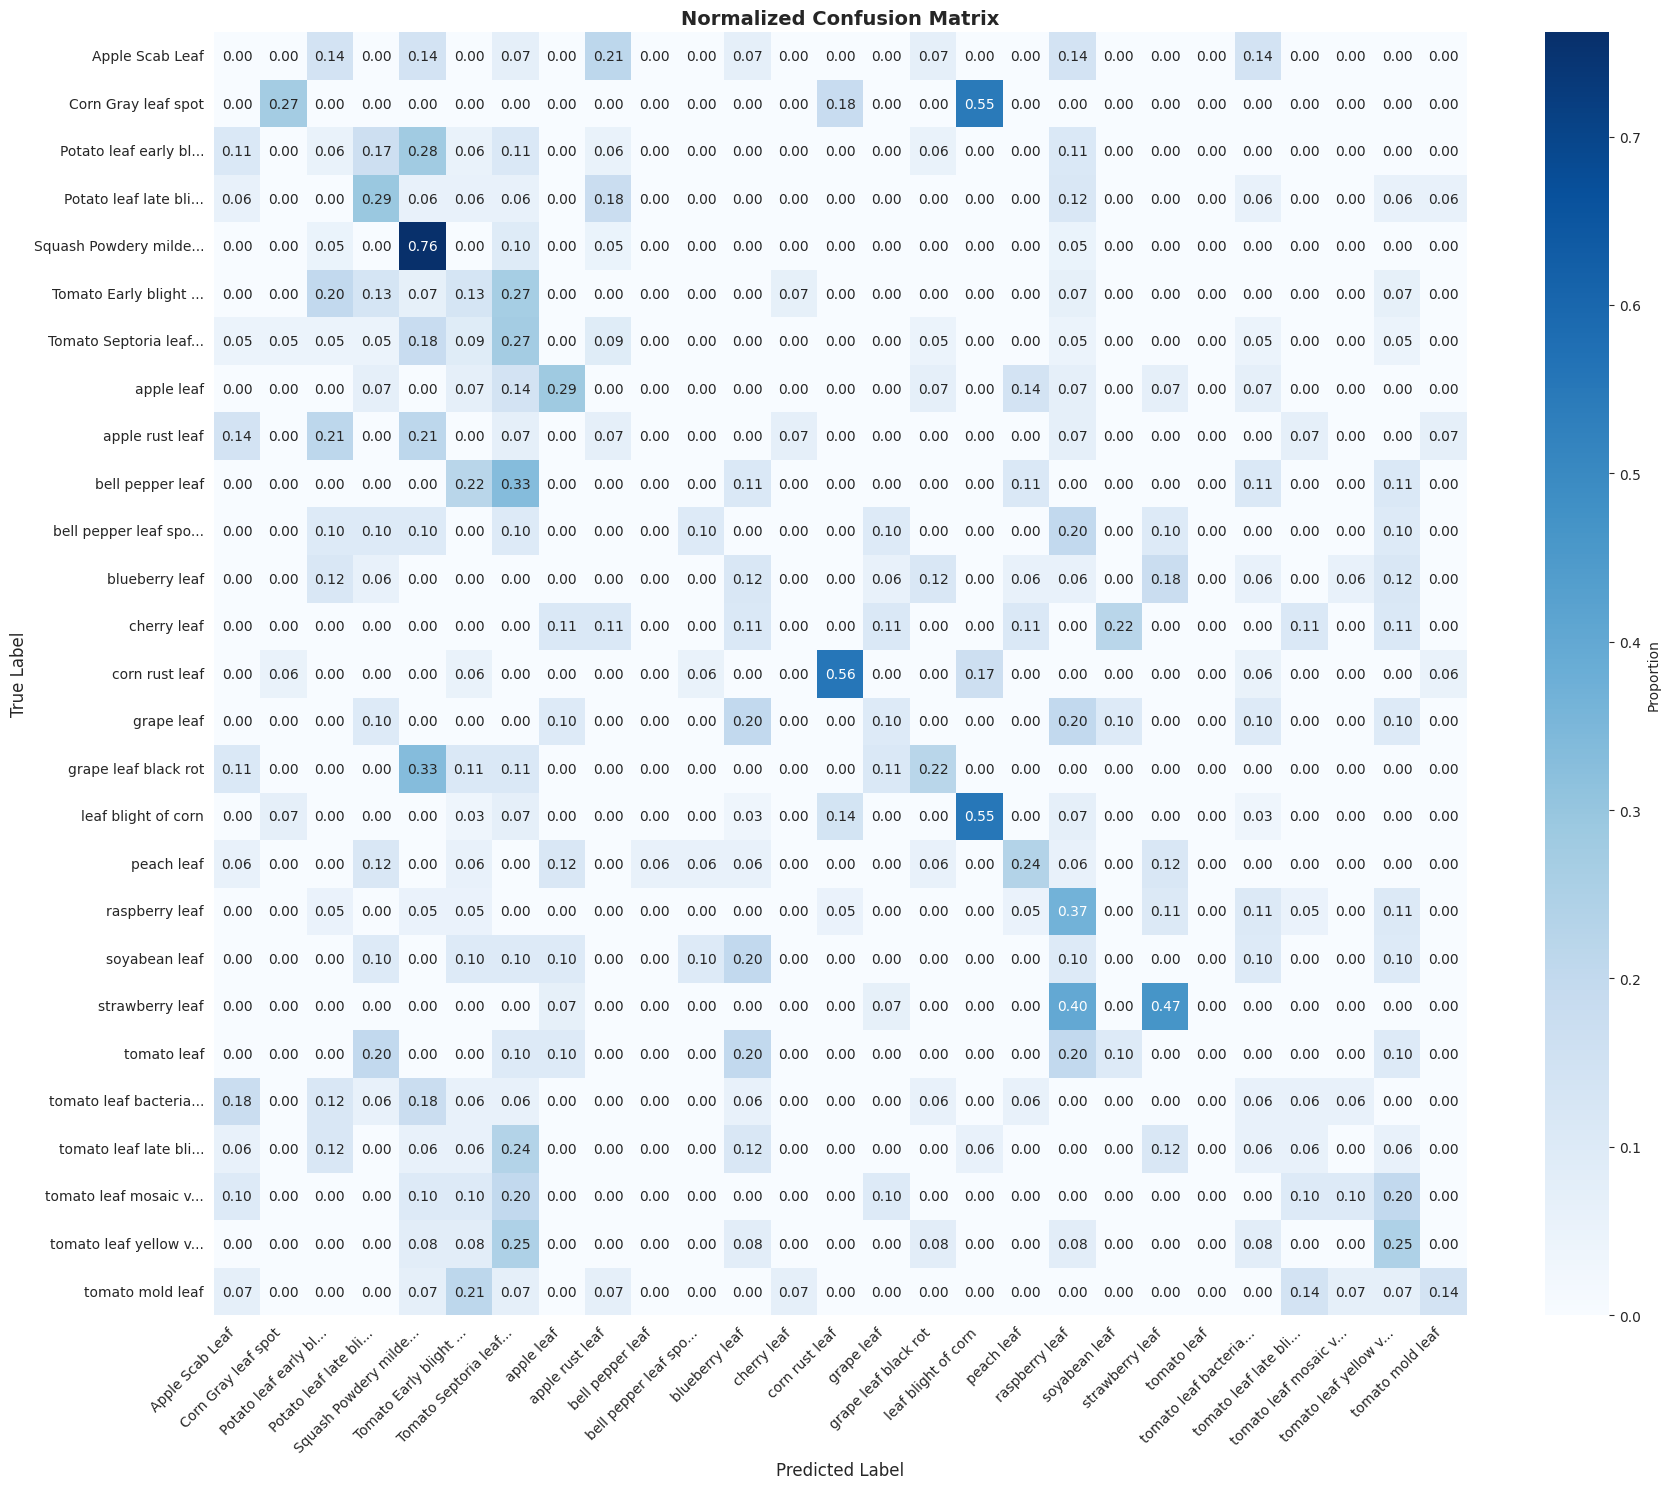


--- 保存结果 ---
未找到 E1 基线结果，仅输出本次实验指标。

✓ 全流程完成


In [8]:
# ===================================================================
# 单元格：PlantDoc 传统基线（优化版）
# ===================================================================
import sys, subprocess, importlib.util
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# 0. 依赖检查
REQUIRED_PKGS = {
    "numpy": "numpy",
    "pandas": "pandas",
    "matplotlib": "matplotlib",
    "seaborn": "seaborn",
    "skimage": "scikit-image",
    "cv2": "opencv-python-headless",
    "sklearn": "scikit-learn",
    "tqdm": "tqdm",
    "PIL": "pillow",
}
def ensure_packages(pkg_map):
    for module_name, pip_name in pkg_map.items():
        if importlib.util.find_spec(module_name) is None:
            print(f"⚙️ 安装依赖: {pip_name}")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name])
ensure_packages(REQUIRED_PKGS)

# 1. 路径设置
sns.set_style("whitegrid")
plt.rcParams["font.sans-serif"] = ["SimHei", "Arial Unicode MS", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False

base_dir = Path("/content/plantdoc")
if not base_dir.exists():
    raise FileNotFoundError(f"未找到 {base_dir}，请先上传或挂载完整项目。")

src_dir = base_dir / "src"
if str(src_dir.resolve()) not in sys.path:
    sys.path.insert(0, str(src_dir.resolve()))

from data.traditional_loader import load_all_splits
from models.traditional_features import (
    extract_hog_features, extract_color_histogram, extract_lbp_features
)
from models.traditional_classifiers import evaluate_model, save_model
from eval.traditional_eval import plot_confusion_matrix

DATA_DIR = base_dir / "data"
SPLIT_JSON = DATA_DIR / "splits" / "plantdoc_split_seed42.json"
PROCESSED_ROOT = DATA_DIR / "processed" / "plantdoc_224"
OUTPUTS_DIR = base_dir / "outputs"
FIGURES_DIR = OUTPUTS_DIR / "figures"
LOGS_DIR = OUTPUTS_DIR / "logs"
CHECKPOINTS_DIR = OUTPUTS_DIR / "checkpoints"
for path in [FIGURES_DIR, LOGS_DIR, CHECKPOINTS_DIR]:
    path.mkdir(parents=True, exist_ok=True)

print("✓ 路径与依赖就绪")

# 2. 加载数据
print("\n--- 加载数据 ---")
splits_data, class_names = load_all_splits(
    split_json_path=SPLIT_JSON,
    processed_root=PROCESSED_ROOT,
    target_size=(256, 256),
    grayscale=False,
)
X_train, y_train, _ = splits_data["train"]
X_val, y_val, _ = splits_data["val"]
X_test, y_test, _ = splits_data["test"]
print(f"训练 {X_train.shape} | 验证 {X_val.shape} | 测试 {X_test.shape}")

# 3. 特征工程（独立降维 + 融合）
def extract_all_features(images):
    return {
        "hog": extract_hog_features(images),
        "color": extract_color_histogram(images, bins=32),
        "lbp": extract_lbp_features(images),
    }

print("\n--- 特征提取 ---")
train_feats = extract_all_features(X_train)
val_feats = extract_all_features(X_val)
test_feats = extract_all_features(X_test)

print("HOG -> StandardScaler + PCA(256)")
hog_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=256, random_state=42)),
])
X_train_hog = hog_pipeline.fit_transform(train_feats["hog"])
X_val_hog = hog_pipeline.transform(val_feats["hog"])
X_test_hog = hog_pipeline.transform(test_feats["hog"])

print("Color+LBP -> StandardScaler")
other_scaler = StandardScaler()
X_train_other = other_scaler.fit_transform(
    np.hstack([train_feats["color"], train_feats["lbp"]])
)
X_val_other = other_scaler.transform(
    np.hstack([val_feats["color"], val_feats["lbp"]])
)
X_test_other = other_scaler.transform(
    np.hstack([test_feats["color"], test_feats["lbp"]])
)

X_train_final = np.hstack([X_train_hog, X_train_other])
X_val_final = np.hstack([X_val_hog, X_val_other])
X_test_final = np.hstack([X_test_hog, X_test_other])
print(f"最终特征维度: {X_train_final.shape[1]}")

# 4. 超参数搜索
print("\n--- GridSearchCV ---")
X_search = np.vstack([X_train_final, X_val_final])
y_search = np.concatenate([y_train, y_val])

param_grid = {"C": [1, 10, 100], "gamma": [0.001, 0.01, 0.1, "scale"]}
grid_search = GridSearchCV(
    SVC(kernel="rbf", class_weight="balanced", random_state=42, probability=True),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
)
grid_search.fit(X_search, y_search)
best_model = grid_search.best_estimator_
print("✓ 最优参数:", grid_search.best_params_)

# 5. 测试集评估
print("\n--- 测试集评估 ---")
metrics = evaluate_model(best_model, X_test_final, y_test, class_names, verbose=True)
plot_confusion_matrix(
    y_test,
    metrics["predictions"],
    class_names,
    save_path=FIGURES_DIR / "E3_final_confusion_matrix.png",
    figsize=(18, 15),
    normalize=True,
)

# 6. 保存模型与结果
print("\n--- 保存结果 ---")
model_path = CHECKPOINTS_DIR / "E3_final_optimized_model.pkl"
save_model(best_model, model_path)

results = pd.DataFrame({
    "experiment": ["E3_Final_Optimized_SVM"],
    "test_accuracy": [metrics["accuracy"]],
    "test_macro_f1": [metrics["macro_f1"]],
    "test_weighted_f1": [metrics["weighted_f1"]],
    "best_params": [str(grid_search.best_params_)],
    "timestamp": [datetime.now().strftime("%Y-%m-%d %H:%M:%S")],
})
results_csv = LOGS_DIR / "experimental_results.csv"
results.to_csv(results_csv, index=False, mode="a", header=not results_csv.exists())

try:
    baseline = pd.read_csv(LOGS_DIR / "E1_hog_svm_results.csv").iloc[0]
    print("\nE3 vs E1 提升：")
    for key in ["test_accuracy", "test_macro_f1", "test_weighted_f1"]:
        print(f"{key}: {baseline[key]:.4f} -> {metrics[key]:.4f} (Δ {metrics[key]-baseline[key]:+.4f})")
except FileNotFoundError:
    print("未找到 E1 基线结果，仅输出本次实验指标。")

print("\n✓ 全流程完成")

In [9]:
# ===================================================================
# 单元格：PlantDoc 传统特征组合消融 (E7)
# ===================================================================
import sys, subprocess, importlib.util
from pathlib import Path
from datetime import datetime
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# 0. 依赖检查
REQUIRED_PKGS = {
    "numpy": "numpy",
    "pandas": "pandas",
    "matplotlib": "matplotlib",
    "seaborn": "seaborn",
    "skimage": "scikit-image",
    "cv2": "opencv-python-headless",
    "sklearn": "scikit-learn",
    "tqdm": "tqdm",
    "PIL": "pillow",
}
def ensure_packages(pkg_map):
    for module_name, pip_name in pkg_map.items():
        if importlib.util.find_spec(module_name) is None:
            print(f"⚙️ 安装依赖: {pip_name}")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name])
ensure_packages(REQUIRED_PKGS)

# 1. 路径设置
sns.set_style("whitegrid")
plt.rcParams["font.sans-serif"] = ["SimHei", "Arial Unicode MS", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False

base_dir = Path("/content/plantdoc")
if not base_dir.exists():
    raise FileNotFoundError(f"未找到 {base_dir}，请先上传或挂载完整项目。")

src_dir = base_dir / "src"
if str(src_dir.resolve()) not in sys.path:
    sys.path.insert(0, str(src_dir.resolve()))

from data.traditional_loader import load_all_splits
from models.traditional_features import (
    extract_hog_features, extract_color_histogram, extract_lbp_features
)
from models.traditional_classifiers import evaluate_model, save_model

DATA_DIR = base_dir / "data"
SPLIT_JSON = DATA_DIR / "splits" / "plantdoc_split_seed42.json"
PROCESSED_ROOT = DATA_DIR / "processed" / "plantdoc_224"
OUTPUTS_DIR = base_dir / "outputs"
LOGS_DIR = OUTPUTS_DIR / "logs"
LOGS_DIR.mkdir(parents=True, exist_ok=True)

print("✓ 路径与依赖就绪")

# 2. 加载数据
print("\n--- 加载数据 ---")
splits_data, class_names = load_all_splits(
    split_json_path=SPLIT_JSON,
    processed_root=PROCESSED_ROOT,
    target_size=(256, 256),
    grayscale=False,
)
X_train, y_train, _ = splits_data["train"]
X_val, y_val, _ = splits_data["val"]
X_test, y_test, _ = splits_data["test"]
print(f"训练 {X_train.shape} | 验证 {X_val.shape} | 测试 {X_test.shape}")

# 3. 预先提取三种基础特征（方便后续组合）
print("\n--- 提取基础特征 (HOG / Color / LBP) ---")
base_features = {
    "HOG": {
        "train": extract_hog_features(X_train),
        "val": extract_hog_features(X_val),
        "test": extract_hog_features(X_test),
    },
    "COLOR": {
        "train": extract_color_histogram(X_train, bins=32),
        "val": extract_color_histogram(X_val, bins=32),
        "test": extract_color_histogram(X_test, bins=32),
    },
    "LBP": {
        "train": extract_lbp_features(X_train),
        "val": extract_lbp_features(X_val),
        "test": extract_lbp_features(X_test),
    },
}

# 4. 定义组合 & 评估函数
def build_features(combo):
    parts = []
    scalers = {}
    if "HOG" in combo:
        hog_pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("pca", PCA(n_components=256, random_state=42)),
        ])
        X_train_hog = hog_pipeline.fit_transform(base_features["HOG"]["train"])
        X_val_hog = hog_pipeline.transform(base_features["HOG"]["val"])
        X_test_hog = hog_pipeline.transform(base_features["HOG"]["test"])
        parts.append(("HOG", X_train_hog, X_val_hog, X_test_hog))
        scalers["HOG_pipeline"] = hog_pipeline

    if {"COLOR", "LBP"} & set(combo):
        feat_list = []
        val_feat_list = []
        test_feat_list = []
        if "COLOR" in combo:
            feat_list.append(base_features["COLOR"]["train"])
            val_feat_list.append(base_features["COLOR"]["val"])
            test_feat_list.append(base_features["COLOR"]["test"])
        if "LBP" in combo:
            feat_list.append(base_features["LBP"]["train"])
            val_feat_list.append(base_features["LBP"]["val"])
            test_feat_list.append(base_features["LBP"]["test"])
        stack_train = np.hstack(feat_list)
        stack_val = np.hstack(val_feat_list)
        stack_test = np.hstack(test_feat_list)
        scaler = StandardScaler()
        X_train_aux = scaler.fit_transform(stack_train)
        X_val_aux = scaler.transform(stack_val)
        X_test_aux = scaler.transform(stack_test)
        parts.append(("AUX", X_train_aux, X_val_aux, X_test_aux))
        scalers["AUX_scaler"] = scaler

    X_train_final = np.hstack([p[1] for p in parts])
    X_val_final = np.hstack([p[2] for p in parts])
    X_test_final = np.hstack([p[3] for p in parts])
    return X_train_final, X_val_final, X_test_final, scalers

def run_experiment(combo_name, combo):
    print(f"\n=== 组合 {combo_name} ===")
    X_train_final, X_val_final, X_test_final, scalers = build_features(combo)
    print(f"特征维度: {X_train_final.shape[1]}")

    X_search = np.vstack([X_train_final, X_val_final])
    y_search = np.concatenate([y_train, y_val])

    param_grid = {"C": [1, 10, 100], "gamma": [0.001, 0.01, 0.1, "scale"]}
    grid = GridSearchCV(
        SVC(kernel="rbf", class_weight="balanced", random_state=42, probability=True),
        param_grid=param_grid,
        cv=3,
        n_jobs=-1,
        verbose=0,
    )
    grid.fit(X_search, y_search)
    best_model = grid.best_estimator_

    metrics = evaluate_model(best_model, X_test_final, y_test, class_names, verbose=False)
    print(f"最佳参数: {grid.best_params_} | Acc={metrics['accuracy']:.4f} MacroF1={metrics['macro_f1']:.4f}")

    return {
        "combo": combo_name,
        "features_used": "+".join(combo),
        "dim": X_train_final.shape[1],
        "best_params": str(grid.best_params_),
        "test_accuracy": metrics["accuracy"],
        "test_macro_f1": metrics["macro_f1"],
        "test_weighted_f1": metrics["weighted_f1"],
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    }

# 5. 构造所有非空组合
feature_names = ["HOG", "COLOR", "LBP"]
combo_defs = []
for r in range(1, len(feature_names) + 1):
    for combo in combinations(feature_names, r):
        combo_defs.append((f"E7_{'+'.join(combo)}", combo))

# 6. 运行消融实验
results = []
for combo_name, combo in combo_defs:
    results.append(run_experiment(combo_name, combo))

results_df = pd.DataFrame(results)
results_csv = LOGS_DIR / "E7_ablation_results.csv"
results_df.to_csv(results_csv, index=False)
print("\n=== 完成 E7 消融 ===")
print(results_df[["combo", "features_used", "test_accuracy", "test_macro_f1"]])
print(f"结果已保存到 {results_csv}")

✓ 路径与依赖就绪

--- 加载数据 ---


Loading test: 100%|██████████| 398/398 [00:02<00:00, 187.01it/s]


训练 (1730, 256, 256, 3) | 验证 (360, 256, 256, 3) | 测试 (398, 256, 256, 3)

--- 提取基础特征 (HOG / Color / LBP) ---

=== 组合 E7_HOG ===
特征维度: 256
最佳参数: {'C': 100, 'gamma': 'scale'} | Acc=0.2412 MacroF1=0.1966

=== 组合 E7_COLOR ===
特征维度: 96
最佳参数: {'C': 10, 'gamma': 'scale'} | Acc=0.2186 MacroF1=0.2010

=== 组合 E7_LBP ===
特征维度: 26
最佳参数: {'C': 100, 'gamma': 0.01} | Acc=0.2136 MacroF1=0.1976

=== 组合 E7_HOG+COLOR ===
特征维度: 352
最佳参数: {'C': 100, 'gamma': 'scale'} | Acc=0.2312 MacroF1=0.1823

=== 组合 E7_HOG+LBP ===
特征维度: 282
最佳参数: {'C': 100, 'gamma': 'scale'} | Acc=0.2387 MacroF1=0.1967

=== 组合 E7_COLOR+LBP ===
特征维度: 122
最佳参数: {'C': 100, 'gamma': 0.001} | Acc=0.2638 MacroF1=0.2421

=== 组合 E7_HOG+COLOR+LBP ===
特征维度: 378
最佳参数: {'C': 100, 'gamma': 'scale'} | Acc=0.2412 MacroF1=0.1933

=== 完成 E7 消融 ===
              combo  features_used  test_accuracy  test_macro_f1
0            E7_HOG            HOG       0.241206       0.196616
1          E7_COLOR          COLOR       0.218593       0.201028
2            E7_